<a href="https://colab.research.google.com/github/sijuswamyresearch/24DS736-DLVR-Assessments/blob/main/Segmentation_of_a_subset_of_Oxfordiit_pet_dataset_using_U_Net_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading dataset

>**Caution:** `oxfordiiit` pet dataset is updated from version 3.0.2 to 4.0.0. Previous code to load this dataset from tensorflow dataset is not working now. So directly extract from vgg dataset.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-03-06 09:05:37--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-03-06 09:05:38--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  18.0MB/s    in 40s     

2025-03-06 09:06:19 (18.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-03-06 09:06:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.r

## Importing libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Setting path to the dataset

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Checking images and their masks

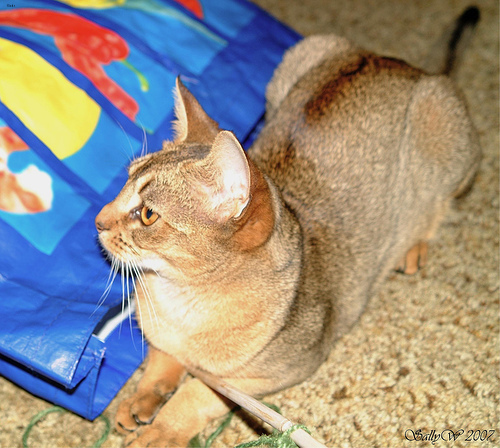

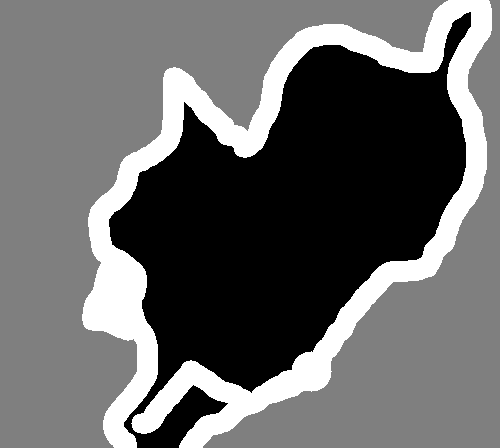

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Utility functions for loading images and corresponding mask

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Creating a U-Net like model (choosing a smaller one for fast training)

In [ ]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 80, 80, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 80, 80, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 80, 80, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 80, 80, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 80, 80, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 40, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40, 40, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 40, 40, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Selecting a small subset for validation (larger sets take much time)

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Compiling and training the model ( This model run only in GPU. Batch size 32 may leads to OOM)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 70s - 2s/step - loss: 1.8689 - val_loss: 1.7399
Epoch 2/50
32/32 - 7s - 209ms/step - loss: 0.9712 - val_loss: 1.5818
Epoch 3/50
32/32 - 12s - 379ms/step - loss: 0.8082 - val_loss: 1.8314
Epoch 4/50
32/32 - 8s - 239ms/step - loss: 0.7198 - val_loss: 2.2459
Epoch 5/50
32/32 - 10s - 320ms/step - loss: 0.6627 - val_loss: 2.7080
Epoch 6/50
32/32 - 6s - 203ms/step - loss: 0.6200 - val_loss: 3.1610
Epoch 7/50
32/32 - 12s - 389ms/step - loss: 0.5848 - val_loss: 3.6118
Epoch 8/50
32/32 - 8s - 240ms/step - loss: 0.5539 - val_loss: 4.0185
Epoch 9/50
32/32 - 10s - 319ms/step - loss: 0.5252 - val_loss: 4.4277
Epoch 10/50
32/32 - 10s - 313ms/step - loss: 0.4978 - val_loss: 4.8211
Epoch 11/50
32/32 - 11s - 330ms/step - loss: 0.4710 - val_loss: 5.2062
Epoch 12/50
32/32 - 10s - 326ms/step - loss: 0.4447 - val_loss: 5.6179
Epoch 13/50
32/32 - 6s - 192ms/step - loss: 0.4188 - val_loss: 5.9811
Epoch 14/50
32/32 - 10s - 312ms/step - loss: 0.3935 - val_loss: 6.3083
Epoch 15/50
32/32 - 6s 

## Visualizing segmentation skill

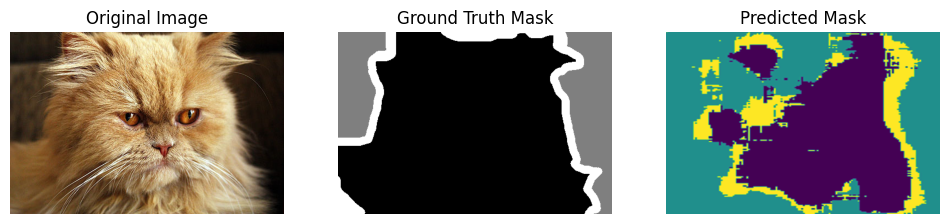

In [ ]:
import matplotlib.pyplot as plt
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import load_img

def display_results(i):
    img = load_img(val_input_img_paths[i])  # Load the original image
    gt_mask = ImageOps.autocontrast(load_img(val_target_img_paths[i]))  # Load the ground truth mask

    # Resize the predicted mask to match the ground truth size
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask_resized = ImageOps.autocontrast(keras.utils.array_to_img(pred_mask).resize(gt_mask.size))

    # Plot the images in a single row
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_resized)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Display results for validation image #8
i = 9
display_results(i)


>**Observation:** The predicted mask is not aligned to the ground truth. Increase number of epoch to 100 make better result. For 20 epoch , the model took 78 minutes in Google T4 GPU!

## Evaluation of the model- Using IOU and DICE score

In [ ]:
import numpy as np
import os
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

def compute_metrics(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, num_classes - 1)
    y_true = np.clip(y_true, 0, num_classes - 1)

    # Compute Intersection over Union (IoU)
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)
    iou_score = iou_metric.result().numpy()

    # Compute Dice coefficient
    intersection = np.sum((y_true == y_pred) & (y_true > 0))
    dice_score = (2. * intersection) / (np.sum(y_true > 0) + np.sum(y_pred > 0) + 1e-6)

    return iou_score, dice_score

iou_scores = []
dice_scores = []

# Check the length of predictions
print(f"Length of val_preds: {len(val_preds)}")

# Align ground truth masks with predictions
target_img_paths = target_img_paths[:len(val_preds)]

for i in range(len(val_preds)):
    gt_mask = load_img(target_img_paths[i], color_mode="grayscale")
    gt_mask = img_to_array(gt_mask)
    gt_mask = resize(gt_mask, img_size, method='nearest').numpy()
    gt_mask = np.squeeze(gt_mask)

    # Explicitly reshape ground truth mask
    gt_mask = gt_mask.reshape(img_size)

    # Flatten the ground truth mask
    gt_mask_flat = gt_mask.flatten().astype(int)

    #print(f"Ground Truth Mask Shape (flattened): {gt_mask_flat.shape}")

    pred_mask = resize(val_preds[i], img_size, method='nearest').numpy()
    pred_mask = np.argmax(pred_mask, axis=-1)

    # Flatten the prediction mask
    pred_mask_flat = pred_mask.flatten().astype(int)

    #print(f"Prediction Mask Shape (flattened): {pred_mask_flat.shape}")

    assert gt_mask_flat.shape == pred_mask_flat.shape, f"Shape mismatch: gt_mask {gt_mask_flat.shape}, pred_mask {pred_mask_flat.shape}"

    iou, dice = compute_metrics(gt_mask_flat, pred_mask_flat)
    iou_scores.append(iou)
    dice_scores.append(dice)

print(f"Average IoU score: {np.mean(iou_scores):.4f}")
print(f"Average Dice score: {np.mean(dice_scores):.4f}")

flat_true = np.concatenate([
    resize(np.expand_dims(np.array(load_img(target_path, color_mode="grayscale")), axis=-1), img_size, method='nearest').numpy().reshape(img_size).flatten().astype(int)
    for target_path in target_img_paths
])

flat_pred = np.concatenate([
    np.argmax(resize(val_preds[i], img_size, method='nearest').numpy(), axis=-1).flatten().astype(int)
    for i in range(len(val_preds))
])

# Ensure valid indices
flat_true = np.clip(flat_true, 0, num_classes - 1)
flat_pred = np.clip(flat_pred, 0, num_classes - 1)

print(classification_report(flat_true, flat_pred))



Length of val_preds: 1000
Average IoU score: 0.0798
Average Dice score: 0.2235


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.19      0.31      0.23   8194285
           2       0.66      0.13      0.22  17405715

    accuracy                           0.19  25600000
   macro avg       0.28      0.15      0.15  25600000
weighted avg       0.51      0.19      0.22  25600000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusion

The model is not properly trained. So both IOU score and DICE score are very low.